In [ ]:
################################ 
# Connect to google drive      #
################################
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
####################
# Libraries        #
####################

import numpy as np
import pandas as pd
from geopy.geocoders import Nominatim
import plotly.graph_objects as go    # for data visualisation
import plotly.express as px
import matplotlib.pyplot as plt

import os
import glob

from sklearn.cluster import DBSCAN

In [ ]:
###########################################
# Read the data from one file             #
###########################################
chunk = pd.read_csv("/content/gdrive/MyDrive/Gas Flaring Brainnwave/vnf_2017/vnf_2017_label_0.01.csv", chunksize=1000000)
df = pd.concat(chunk)

In [ ]:
display(df.head())
# df.describe()
print("The columns of df: \n{}".format(df.columns))
print("\nThe dimentions of df:{}".format(df.shape))
# df.dtypes

,id_Key,Date_Mscan,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,Date,Above_1400K,Label
0,x0836342E_y684144N_l2140_s3091_v21,2017/01/01 01:03:38.689,68.414368,83.634171,1733.0,33.65390,67.0111,131.0860,0.0,3091,2017-01-01,True,0
1,x0836410E_y684024N_l2140_s3092_v21,2017/01/01 01:03:38.689,68.402435,83.640961,1884.0,14.46620,28.8822,40.4495,0.0,3092,2017-01-01,True,0
2,x0835980E_y684115N_l2141_s3091_v21,2017/01/01 01:03:38.689,68.411530,83.598038,1773.0,7.22975,14.3959,25.6943,0.0,3091,2017-01-01,True,0
3,x0836047E_y683998N_l2141_s3092_v21,2017/01/01 01:03:38.689,68.399780,83.604691,1517.0,5.98360,11.9463,39.7925,0.0,3092,2017-01-01,True,0
4,x0836079E_y684145N_l2149_s3091_v21,2017/01/01 01:03:40.468,68.414467,83.607948,1789.0,30.08700,59.8867,103.1950,0.0,3091,2017-01-01,True,0


The columns of df: 
Index(['id_Key', 'Date_Mscan', 'Lat_GMTCO', 'Lon_GMTCO', 'Temp_BB', 'RHI',
       'RH', 'Area_BB', 'Cloud_Mask', 'Sample_M10', 'Date', 'Above_1400K',
       'Label'],
      dtype='object')

The dimentions of df:(3332951, 13)


In [ ]:
df.groupby(["Label"])["Lat_GMTCO","Lon_GMTCO"].count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



<bound method DataFrameGroupBy.count of <pandas.core.groupby.generic.DataFrameGroupBy object at 0x7f7cb8434750>>

In [ ]:
num_clusters = df["Label"].max() + 1
print(num_clusters)

clusters = pd.Series([df.loc[df["Label"]==n,["Lat_GMTCO","Lon_GMTCO"]].values for n in range(num_clusters)])
clusters

8363


0       [[68.41436800000001, 83.634171], [68.402435, 8...
1       [[69.61797299999999, 81.81869499999998], [69.6...
2       [[68.532013, 79.945961], [68.521263, 79.953987...
3       [[67.815376, 72.527374], [67.80534399999999, 7...
4       [[66.15451800000001, 71.085075], [66.142508999...
                              ...                        
8358    [[-25.100388, 115.573669], [-25.575878, 115.37...
8359                             [[-1.257702, 38.145298]]
8360                   [[82.92536899999998, -159.416885]]
8361                             [[72.686157, -26.46735]]
8362                            [[33.588169, 103.101608]]
Length: 8363, dtype: object

In [ ]:
#clusters.to_csv("/content/gdrive/MyDrive/Gas Flaring Brainnwave/vnf_2017/vnf_2017_label_DBSCANFinalWith0.01_clustersOfLatLon.csv")

In [ ]:
# Number of sites in each cluster
clusters_ = df.groupby(["Label"]).apply(lambda x: [list(x["Lat_GMTCO"]), list(x["Lon_GMTCO"])]) #df.groupby(["Label"])["Lat_GMTCO", "Lon_GMTCO"].agg(list)

In [ ]:
clusters[1000] 

array([[ -14.764092, -135.235062],
       [ -14.826766, -135.149902],
       [ -14.84849 , -135.183884],
       [ -14.851451, -135.170303]])

In [ ]:
clusters_[1000]

[[-14.764092000000002, -14.826766000000001, -14.84849, -14.851451],
 [-135.235062, -135.149902, -135.183884, -135.170303]]

In [ ]:
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)
centermost_points

0                 (68.342049, 83.646461)
1                 (69.616936, 81.823418)
2                 (40.230289, 69.685799)
3                 (67.800842, 72.513306)
4                 (66.196159, 70.990173)
                      ...               
8358            (-25.580359, 115.391129)
8359              (-1.257702, 38.145298)
8360    (82.92536899999998, -159.416885)
8361              (72.686157, -26.46735)
8362             (33.588169, 103.101608)
Length: 8363, dtype: object

In [ ]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'Lat_GMTCO_Label':lats, 'Lon_GMTCO_Label':lons})
rep_points["Label"] = np.arange(0, num_clusters,1).tolist()
rep_points

,Lat_GMTCO_Label,Lon_GMTCO_Label,Label
0,68.342049,83.646461,0
1,69.616936,81.823418,1
2,40.230289,69.685799,2
3,67.800842,72.513306,3
4,66.196159,70.990173,4
...,...,...,...
8358,-25.580359,115.391129,8358
8359,-1.257702,38.145298,8359
8360,82.925369,-159.416885,8360
8361,72.686157,-26.467350,8361


# Add extra column for temperature, latitude, longitude according to the cluster label

In [ ]:
#df_test["Temp_BB"].groupby([df_test["Label"], df_test["Date"]]).transform("max")

In [ ]:
df_test = df.copy()
df_test["Temp_BB_Max_Label"] = df_test["Temp_BB"].groupby(df_test["Label"]).transform("max")
df_test["Temp_BB_Min_Label"] = df_test["Temp_BB"].groupby(df_test["Label"]).transform("min")
df_test["Temp_BB_Mean_Label"] = df_test["Temp_BB"].groupby(df_test["Label"]).transform("mean")
df_test["Temp_BB_Std_Label"] = df_test["Temp_BB"].groupby(df_test["Label"]).transform("std")
df_test["Temp_BB_Label_Day"] = df_test["Temp_BB"].groupby([df_test["Label"], df_test["Date"]]).transform("max")

df_test["Area_BB_Max_Label"] = df_test["Area_BB"].groupby(df_test["Label"]).transform("max")
df_test["Area_BB_Min_Label"] = df_test["Area_BB"].groupby(df_test["Label"]).transform("min")
df_test["Area_BB_Mean_Label"] = df_test["Area_BB"].groupby(df_test["Label"]).transform("mean")
df_test["Area_BB_StdLabel"] = df_test["Area_BB"].groupby(df_test["Label"]).transform("std")
df_test["Area_BB_Label_Day"] = df_test["Area_BB"].groupby([df_test["Label"], df_test["Date"]]).transform("max")

df_test["RHI_Max_Label"] = df_test["RHI"].groupby(df_test["Label"]).transform("max")
df_test["RHI_Min_Label"] = df_test["RHI"].groupby(df_test["Label"]).transform("min")
df_test["RHI_Mean_Label"] = df_test["RHI"].groupby(df_test["Label"]).transform("mean")
df_test["RHI_StdLabel"] = df_test["RHI"].groupby(df_test["Label"]).transform("std")
df_test["RHI_Label_Day"] = df_test["RHI"].groupby([df_test["Label"], df_test["Date"]]).transform("max")



In [ ]:
df_test[df_test["Label"]==10]

,id_Key,Date_Mscan,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,Date,Above_1400K,Label,Temp_BB_Max_Label,Temp_BB_Min_Label,Temp_BB_Mean_Label,Temp_BB_Std_Label,Temp_BB_Label_Day,Area_BB_Max_Label,Area_BB_Min_Label,Area_BB_Mean_Label,Area_BB_StdLabel,Area_BB_Label_Day,RHI_Max_Label,RHI_Min_Label,RHI_Mean_Label,RHI_StdLabel,RHI_Label_Day
101,x0222921E_y602845N_l2677_s1795_v21,2017/01/01 01:10:20.804,60.284527,22.292099,822.0,1.988110,1.214110,46.83320,3.0,1795,2017-01-01,False,10,2479.0,701.0,1462.984962,494.218269,913.0,158.122,0.222485,21.886874,25.228104,46.83320,52.3163,0.402021,2.689803,4.290129,1.988110
3651,x0222909E_y602866N_l1190_s3041_v21,2017/01/01 02:50:00.930,60.286564,22.290897,913.0,0.515433,0.901333,22.91860,3.0,3041,2017-01-01,False,10,2479.0,701.0,1462.984962,494.218269,913.0,158.122,0.222485,21.886874,25.228104,46.83320,52.3163,0.402021,2.689803,4.290129,1.988110
9262,x0222915E_y602839N_l1962_s1482_v21,2017/01/02 00:51:30.531,60.283947,22.291464,843.0,2.049130,1.206090,42.16310,0.0,1482,2017-01-02,False,10,2479.0,701.0,1462.984962,494.218269,843.0,158.122,0.222485,21.886874,25.228104,42.16310,52.3163,0.402021,2.689803,4.290129,2.049130
26735,x0222854E_y602864N_l1207_s1185_v21,2017/01/03 00:32:38.481,60.286438,22.285383,851.0,2.391420,1.820240,61.26160,3.0,1185,2017-01-03,False,10,2479.0,701.0,1462.984962,494.218269,851.0,158.122,0.222485,21.886874,25.228104,61.26160,52.3163,0.402021,2.689803,4.290129,2.391420
29586,x0254731E_y602922N_l2701_s0826_v21,2017/01/04 23:54:41.927,60.292233,25.473143,1587.0,1.404390,1.336070,3.71263,0.0,826,2017-01-04,True,10,2479.0,701.0,1462.984962,494.218269,1587.0,158.122,0.222485,21.886874,25.228104,3.71263,52.3163,0.402021,2.689803,4.290129,1.404390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3255691,x0222929E_y602837N_l0663_s0919_v30,2017/12/22 00:12:55.848,60.283688,22.292910,840.0,1.320550,1.058690,37.53010,3.0,919,2017-12-22,False,10,2479.0,701.0,1462.984962,494.218269,840.0,158.122,0.222485,21.886874,25.228104,45.78730,52.3163,0.402021,2.689803,4.290129,1.320550
3259406,x0222945E_y602886N_l0312_s2385_v30,2017/12/22 01:53:16.897,60.288647,22.294529,834.0,1.293780,1.253110,45.78730,1.0,2385,2017-12-22,False,10,2479.0,701.0,1462.984962,494.218269,840.0,158.122,0.222485,21.886874,25.228104,45.78730,52.3163,0.402021,2.689803,4.290129,1.320550
3267023,x0222874E_y602830N_l0596_s0343_v30,2017/12/23 23:34:57.509,60.283039,22.287405,865.0,0.878961,1.040580,32.72850,3.0,343,2017-12-23,False,10,2479.0,701.0,1462.984962,494.218269,865.0,158.122,0.222485,21.886874,25.228104,32.72850,52.3163,0.402021,2.689803,4.290129,0.878961
3274019,x0222909E_y602851N_l0502_s1890_v30,2017/12/24 01:15:47.026,60.285122,22.290894,811.0,1.267140,0.832489,33.87360,0.0,1890,2017-12-24,False,10,2479.0,701.0,1462.984962,494.218269,811.0,158.122,0.222485,21.886874,25.228104,33.87360,52.3163,0.402021,2.689803,4.290129,1.267140


In [ ]:
# df_test["Lat_GMTCO_Label"] = df_test.merge(rep_points, on="Label")['Lat_GMTCO_Label']#df_test.apply(lambda row: rep_points.iloc[row.Label][1], axis=1)
# df_test["Lon_GMTCO_Label"] = df_test.merge(rep_points, on="Label")['Lon_GMTCO_Label']#df_test.apply(lambda row: rep_points.iloc[row.Label][0], axis=1) #

df_merge = df_test.merge(rep_points, on="Label")
df_merge
df_merge[df_merge["Label"]==9]

#df_merge.to_csv("/content/gdrive/MyDrive/Gas Flaring Brainnwave/vnf_2017/vnf_2017_label_DBSCANFinalWith0.01.csv")

,id_Key,Date_Mscan,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,Date,Above_1400K,Label,Temp_BB_Max_Label,Temp_BB_Min_Label,Temp_BB_Mean_Label,Temp_BB_Std_Label,Temp_BB_Label_Day,Area_BB_Max_Label,Area_BB_Min_Label,Area_BB_Mean_Label,Area_BB_StdLabel,Area_BB_Label_Day,RHI_Max_Label,RHI_Min_Label,RHI_Mean_Label,RHI_StdLabel,RHI_Label_Day,Lat_GMTCO_Label,Lon_GMTCO_Label
1244172,x0212825E_y646655N_l2080_s1507_v21,2017/01/01 01:09:13.192,64.665489,21.282507,860.0,2.205830,1.287730,41.5857,0.0,1507,2017-01-01,False,9,1669.0,712.0,993.523077,171.909567,997.0,210.654,2.0296,64.260764,43.157594,72.8286,38.5095,0.298764,4.10382,4.825643,3.32785,64.666626,21.26433
1244173,x0212735E_y646619N_l2081_s1507_v21,2017/01/01 01:09:14.971,64.661949,21.273546,828.0,3.327850,1.942640,72.8286,0.0,1507,2017-01-01,False,9,1669.0,712.0,993.523077,171.909567,997.0,210.654,2.0296,64.260764,43.157594,72.8286,38.5095,0.298764,4.10382,4.825643,3.32785,64.666626,21.26433
1244174,x0212795E_y646682N_l0746_s2629_v21,2017/01/01 02:49:11.110,64.668190,21.279501,891.0,1.798550,1.451570,40.6387,0.0,2629,2017-01-01,False,9,1669.0,712.0,993.523077,171.909567,997.0,210.654,2.0296,64.260764,43.157594,72.8286,38.5095,0.298764,4.10382,4.825643,3.32785,64.666626,21.26433
1244175,x0212904E_y646639N_l0746_s2630_v21,2017/01/01 02:49:11.110,64.663933,21.290398,997.0,2.785210,2.251190,40.2061,0.0,2630,2017-01-01,False,9,1669.0,712.0,993.523077,171.909567,997.0,210.654,2.0296,64.260764,43.157594,72.8286,38.5095,0.298764,4.10382,4.825643,3.32785,64.666626,21.26433
1244176,x0212705E_y646640N_l0570_s1028_v21,2017/01/03 00:31:27.310,64.663956,21.270452,900.0,1.100500,1.100980,29.5504,3.0,1028,2017-01-03,False,9,1669.0,712.0,993.523077,171.909567,900.0,210.654,2.0296,64.260764,43.157594,29.5504,38.5095,0.298764,4.10382,4.825643,1.10050,64.666626,21.26433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1244427,x0212778E_y646569N_l0590_s0090_v30,2017/12/24 23:14:34.717,64.656944,21.277842,1011.0,1.442890,3.039040,51.3545,NaN,90,2017-12-24,False,9,1669.0,712.0,993.523077,171.909567,1528.0,210.654,2.0296,64.260764,43.157594,81.3504,38.5095,0.298764,4.10382,4.825643,5.59599,64.666626,21.26433
1244428,x0212713E_y646646N_l0598_s0090_v30,2017/12/24 23:14:36.496,64.664642,21.271286,998.0,1.632860,3.438210,61.2129,1.0,90,2017-12-24,False,9,1669.0,712.0,993.523077,171.909567,1528.0,210.654,2.0296,64.260764,43.157594,81.3504,38.5095,0.298764,4.10382,4.825643,5.59599,64.666626,21.26433
1244429,x0213002E_y646660N_l0598_s0091_v30,2017/12/24 23:14:36.496,64.666023,21.300207,1528.0,0.298764,0.627352,2.0296,1.0,91,2017-12-24,True,9,1669.0,712.0,993.523077,171.909567,1528.0,210.654,2.0296,64.260764,43.157594,81.3504,38.5095,0.298764,4.10382,4.825643,5.59599,64.666626,21.26433
1244430,x0212840E_y646646N_l0084_s2703_v30,2017/12/24 02:54:35.554,64.664566,21.284006,1173.0,5.595990,5.055210,47.1000,1.0,2703,2017-12-24,False,9,1669.0,712.0,993.523077,171.909567,1528.0,210.654,2.0296,64.260764,43.157594,81.3504,38.5095,0.298764,4.10382,4.825643,5.59599,64.666626,21.26433


In [ ]:
#df_merge.to_csv("/content/gdrive/MyDrive/Gas Flaring Brainnwave/vnf_2017/vnf_2017_label_DBSCANFinalWith0.01.csv")

In [ ]:
df_merge.head()
df_merge.shape

(3332951, 17)

In [ ]:
rs = rep_points.apply(lambda row: df_merge[(df_merge['Lat_GMTCO']==row['Lat_GMTCO_Label']) & (df_merge['Lon_GMTCO']==row['Lon_GMTCO_Label'])].iloc[0], axis=1)
rs

,id_Key,Date_Mscan,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,Date,Above_1400K,Label,Temp_BB_Max_Label,Temp_BB_Min_Label,Temp_BB_Mean_Label,Temp_BB_Std_Label,Temp_BB_Label_Day,Area_BB_Max_Label,Area_BB_Min_Label,Area_BB_Mean_Label,Area_BB_StdLabel,Area_BB_Label_Day,RHI_Max_Label,RHI_Min_Label,RHI_Mean_Label,RHI_StdLabel,RHI_Label_Day,Lat_GMTCO_Label,Lon_GMTCO_Label
0,x0836465E_y683420N_l0120_s3107_v30,2017/12/08 01:09:08.285,68.342049,83.646461,1744.0,0.584813,1.214580,2.31519,0.0,3107,2017-12-08,True,0,2500.0,568.0,1898.674828,252.242898,2466.0,408.39400,0.077106,10.208099,23.992157,39.10430,167.182000,0.257069,4.653799,10.186574,10.838800,68.342049,83.646461
1,x0818234E_y696169N_l2760_s0090_v21,2017/03/08 19:05:58.076,69.616936,81.823418,1715.0,1.721590,3.624510,7.39666,NaN,90,2017-03-08,True,1,2383.0,858.0,1737.500000,180.246612,1717.0,65.02790,0.188412,5.701944,6.691500,11.35250,14.961900,0.261412,2.263005,1.636818,5.745990,69.616936,81.823418
2,x0696858E_y402303N_l0461_s0015_v21,2017/06/20 20:05:05.372,40.230289,69.685799,803.0,1.620070,4.222050,178.64600,NaN,15,2017-06-20,False,2,2500.0,424.0,1411.340241,404.974136,2439.0,37491.50000,-5518.830000,41.525190,144.283594,11850.70000,2124.210000,-3.775210,5.896589,16.855090,476.008000,40.230289,69.685799
3,x0725133E_y678008N_l0083_s2134_v21,2017/10/22 22:54:25.206,67.800842,72.513306,2154.0,1.849290,1.708210,1.39915,0.0,2134,2017-10-22,True,3,2500.0,636.0,2001.633032,197.206922,2436.0,6824.25000,0.067479,14.508643,104.460702,9.85576,604.872000,0.255522,6.878640,25.523127,6.192030,67.800842,72.513306
4,x0709902E_y661962N_l0169_s3097_v30,2017/12/25 00:51:57.838,66.196159,70.990173,1856.0,22.100600,44.647700,66.35050,3.0,3097,2017-12-25,True,4,2500.0,755.0,1976.336691,221.493093,2145.0,1513.43000,0.064723,12.866282,45.500674,1513.43000,289.170000,0.239211,6.874422,21.115677,142.920000,66.196159,70.990173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8358,x1153911E_y255804S_l0506_s0002_v30,2017/12/31 16:23:09.636,-25.580359,115.391129,976.0,1.472800,4.066540,78.93980,0.0,2,2017-12-31,False,8358,986.0,958.0,973.333333,14.189198,986.0,80.38940,71.847600,77.058933,4.570977,80.38940,1.472800,1.387200,1.416507,0.048765,1.472800,-25.580359,115.391129
8359,x0381453E_y012577S_l0355_s1928_v30,2017/12/31 23:01:12.770,-1.257702,38.145298,1316.0,0.721829,0.492417,2.89519,0.0,1928,2017-12-31,False,8359,1316.0,1316.0,1316.000000,NaN,1316.0,2.89519,2.895190,2.895190,NaN,2.89519,0.721829,0.721829,0.721829,NaN,0.721829,-1.257702,38.145298
8360,x1594169W_y829254N_l0712_s0990_v30,2017/12/31 14:09:50.038,82.925369,-159.416885,886.0,0.199344,0.142620,4.08640,0.0,990,2017-12-31,False,8360,886.0,886.0,886.000000,NaN,886.0,4.08640,4.086400,4.086400,NaN,4.08640,0.199344,0.199344,0.199344,NaN,0.199344,82.925369,-159.416885
8361,x0264674W_y726862N_l0623_s2006_v30,2017/12/31 12:22:59.327,72.686157,-26.467350,932.0,0.819348,0.614544,14.34760,1.0,2006,2017-12-31,False,8361,932.0,932.0,932.000000,NaN,932.0,14.34760,14.347600,14.347600,NaN,14.34760,0.819348,0.819348,0.819348,NaN,0.819348,72.686157,-26.467350


In [ ]:
#rs.to_csv("/content/gdrive/MyDrive/Gas Flaring Brainnwave/vnf_2017/vnf_2017_label_DBSCANFinalWith0.01_onlyCenterMostPoint.csv")

# Remove extra rows that are in the same cluster and date >>> Just leave one row to represent

In [ ]:
df_merge_smaller = df_merge.drop_duplicates(["Date","Label"]) #df_merge.groupby(["Date","Label"]).first()
df_merge_smaller

,id_Key,Date_Mscan,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,Date,Above_1400K,Label,Temp_BB_Max_Label,Temp_BB_Min_Label,Temp_BB_Mean_Label,Temp_BB_Std_Label,Temp_BB_Label_Day,Area_BB_Max_Label,Area_BB_Min_Label,Area_BB_Mean_Label,Area_BB_StdLabel,Area_BB_Label_Day,RHI_Max_Label,RHI_Min_Label,RHI_Mean_Label,RHI_StdLabel,RHI_Label_Day,Lat_GMTCO_Label,Lon_GMTCO_Label
0,x0836342E_y684144N_l2140_s3091_v21,2017/01/01 01:03:38.689,68.414368,83.634171,1733.0,33.653900,67.011100,131.086000,0.0,3091,2017-01-01,True,0,2500.0,568.0,1898.674828,252.242898,2271.0,408.39400,0.077106,10.208099,23.992157,131.08600,167.182000,0.257069,4.653799,10.186574,70.131700,68.342049,83.646461
37,x0835785E_y684195N_l1562_s0312_v21,2017/01/02 19:26:00.832,68.419495,83.578499,2051.0,1.015930,1.278670,1.273180,0.0,312,2017-01-02,True,0,2500.0,568.0,1898.674828,252.242898,2265.0,408.39400,0.077106,10.208099,23.992157,107.44200,167.182000,0.257069,4.653799,10.186574,33.949800,68.342049,83.646461
101,x0835916E_y684176N_l0713_s0136_v21,2017/01/03 19:06:56.328,68.417633,83.591629,1761.0,3.410900,6.362670,11.662700,0.0,136,2017-01-03,True,0,2500.0,568.0,1898.674828,252.242898,2269.0,408.39400,0.077106,10.208099,23.992157,97.74270,167.182000,0.257069,4.653799,10.186574,75.040500,68.342049,83.646461
177,x0836142E_y684173N_l0397_s2932_v21,2017/01/04 00:07:55.915,68.417336,83.614189,1879.0,4.240250,5.804870,8.217190,0.0,2932,2017-01-04,True,0,2500.0,568.0,1898.674828,252.242898,2206.0,408.39400,0.077106,10.208099,23.992157,154.53100,167.182000,0.257069,4.653799,10.186574,57.780500,68.342049,83.646461
225,x0836722E_y684161N_l2269_s2715_v21,2017/01/05 23:30:42.061,68.416130,83.672218,2038.0,0.774357,0.713339,0.729951,0.0,2715,2017-01-05,True,0,2500.0,568.0,1898.674828,252.242898,2227.0,408.39400,0.077106,10.208099,23.992157,105.30200,167.182000,0.257069,4.653799,10.186574,30.285500,68.342049,83.646461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332944,x1155737E_y251004S_l0427_s0001_v30,2017/12/31 16:23:00.739,-25.100388,115.573669,958.0,1.387200,3.843060,80.389400,0.0,1,2017-12-31,False,8358,986.0,958.0,973.333333,14.189198,986.0,80.38940,71.847600,77.058933,4.570977,80.38940,1.472800,1.387200,1.416507,0.048765,1.472800,-25.580359,115.391129
3332947,x0381453E_y012577S_l0355_s1928_v30,2017/12/31 23:01:12.770,-1.257702,38.145298,1316.0,0.721829,0.492417,2.895190,0.0,1928,2017-12-31,False,8359,1316.0,1316.0,1316.000000,NaN,1316.0,2.89519,2.895190,2.895190,NaN,2.89519,0.721829,0.721829,0.721829,NaN,0.721829,-1.257702,38.145298
3332948,x1594169W_y829254N_l0712_s0990_v30,2017/12/31 14:09:50.038,82.925369,-159.416885,886.0,0.199344,0.142620,4.086400,0.0,990,2017-12-31,False,8360,886.0,886.0,886.000000,NaN,886.0,4.08640,4.086400,4.086400,NaN,4.08640,0.199344,0.199344,0.199344,NaN,0.199344,82.925369,-159.416885
3332949,x0264674W_y726862N_l0623_s2006_v30,2017/12/31 12:22:59.327,72.686157,-26.467350,932.0,0.819348,0.614544,14.347600,1.0,2006,2017-12-31,False,8361,932.0,932.0,932.000000,NaN,932.0,14.34760,14.347600,14.347600,NaN,14.34760,0.819348,0.819348,0.819348,NaN,0.819348,72.686157,-26.467350


In [ ]:
df_merge.shape

(3332951, 17)

In [ ]:
df_merge_smaller.shape

(55348, 17)

In [ ]:
df_merge_smaller.groupby(["Label"])["Lat_GMTCO"].count()


Label
0       239
1       131
2       358
3       246
4       243
       ... 
8358      1
8359      1
8360      1
8361      1
8362      1
Name: Lat_GMTCO, Length: 8363, dtype: int64

In [ ]:
sizeEachCLuster[sizeEachCLuster>=358]

Label
2    358
Name: Lat_GMTCO, dtype: int64

(array([239., 131., 358., ...,   1.,   1.,   1.]),
 array([0.00000000e+00, 9.99880426e-01, 1.99976085e+00, ...,
        8.36000024e+03, 8.36100012e+03, 8.36200000e+03]),
 <a list of 8363 Patch objects>)

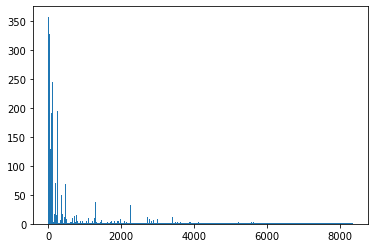

In [ ]:
#plt.hist(df_merge_smaller[df_merge_smaller["Label"]<50]["Label"], bins=50)
plt.hist(df_merge_smaller["Label"], bins=8363)

In [ ]:
#df_merge_smaller.to_csv("/content/gdrive/MyDrive/Gas Flaring Brainnwave/vnf_2017/vnf_2017_label_DBSCANFinalWith0.01_COMPRESSED.csv")

In [ ]:
### FOR CHECKING
unique_dates = df_merge["Date"].unique()
df_merge[(df_merge["Label"]==1) & (df_merge["Date"]==unique_dates[0])]

,id_Key,Date_Mscan,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,Date,Above_1400K,Label,Temp_BB_Label,Temp_BB_Label_Day,Lat_GMTCO_Label,Lon_GMTCO_Label
6821,x0818187E_y696180N_l2200_s2969_v21,2017/01/01 01:03:45.806,69.617973,81.818695,1885.0,1.98728,2.946680,4.11289,0.0,2969,2017-01-01,True,1,2383.0,1943.0,69.616936,81.823418
6822,x0818296E_y696250N_l1435_s1492_v21,2017/01/01 21:25:42.400,69.625046,81.829590,1848.0,3.18206,1.866320,2.82096,0.0,1492,2017-01-01,True,1,2383.0,1943.0,69.616936,81.823418
6823,x0818218E_y696189N_l1436_s1492_v21,2017/01/01 21:25:42.400,69.618851,81.821838,1605.0,1.27771,0.749401,1.99364,0.0,1492,2017-01-01,True,1,2383.0,1943.0,69.616936,81.823418
6824,x0818394E_y696257N_l0168_s2387_v21,2017/01/01 23:05:47.435,69.625702,81.839409,1943.0,1.04387,1.015640,1.25604,0.0,2387,2017-01-01,True,1,2383.0,1943.0,69.616936,81.823418
6825,x0818202E_y696197N_l0169_s2387_v21,2017/01/01 23:05:47.435,69.619690,81.820152,1819.0,5.17860,5.038500,8.11522,0.0,2387,2017-01-01,True,1,2383.0,1943.0,69.616936,81.823418
6826,x0818155E_y696223N_l2205_s0448_v21,2017/01/01 19:44:42.209,69.622307,81.815521,1745.0,2.15151,2.115480,4.02633,0.0,448,2017-01-01,True,1,2383.0,1943.0,69.616936,81.823418
6827,x0818362E_y696223N_l2205_s0449_v21,2017/01/01 19:44:42.209,69.622345,81.836205,1874.0,2.51342,2.467210,3.52659,0.0,449,2017-01-01,True,1,2383.0,1943.0,69.616936,81.823418
6828,x0818289E_y696192N_l2212_s0449_v21,2017/01/01 19:44:43.988,69.619186,81.828880,1801.0,3.87565,3.804530,6.38025,0.0,449,2017-01-01,True,1,2383.0,1943.0,69.616936,81.823418
6829,x0818287E_y696229N_l0363_s2988_v21,2017/01/01 02:42:46.788,69.622940,81.828720,1654.0,2.63106,4.070080,9.58086,0.0,2988,2017-01-01,True,1,2383.0,1943.0,69.616936,81.823418
6830,x0818231E_y696133N_l0363_s2989_v21,2017/01/01 02:42:46.788,69.613251,81.823112,1902.0,1.15022,1.783320,2.40435,0.0,2989,2017-01-01,True,1,2383.0,1943.0,69.616936,81.823418


In [ ]:
#### FOR CHECKING
df_merge_smaller[(df_merge["Label"]==1) & (df_merge_smaller["Date"]==unique_dates[0])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,id_Key,Date_Mscan,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,Date,Above_1400K,Label,Temp_BB_Label,Temp_BB_Label_Day,Lat_GMTCO_Label,Lon_GMTCO_Label
6821,x0818187E_y696180N_l2200_s2969_v21,2017/01/01 01:03:45.806,69.617973,81.818695,1885.0,1.98728,2.94668,4.11289,0.0,2969,2017-01-01,True,1,2383.0,1943.0,69.616936,81.823418


# Plot latitude and longitude of one cluster


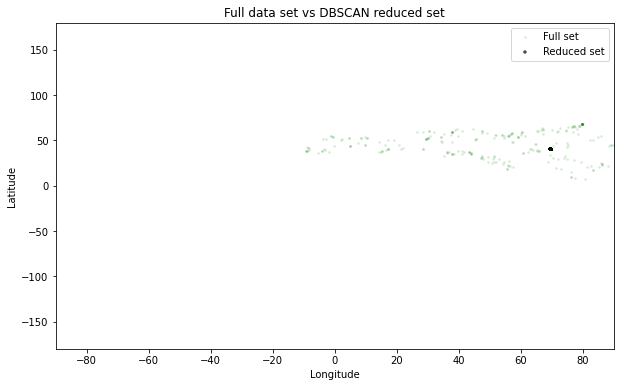

In [ ]:
df_selected = df_merge_smaller.copy()
df_selected = df_selected[df_selected["Label"]==2]

fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(df_selected['Lon_GMTCO_Label'], df_selected['Lat_GMTCO_Label'], c='black', edgecolor='None', alpha=0.7, s=12)
df_scatter = ax.scatter(df_selected['Lon_GMTCO'], df_selected['Lat_GMTCO'], c='green', alpha=0.1, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.xlim([-90, 90])
plt.ylim([-180, 180])
plt.show()

In [ ]:
df_selected.describe()

,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,Label,Temp_BB_Label,Temp_BB_Label_Day,Lat_GMTCO_Label,Lon_GMTCO_Label
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,365.000000,401.000000,401.0,401.0,401.000000,4.010000e+02,4.010000e+02
mean,40.871343,9.193743,1129.179551,14.501292,14.140259,206.407382,0.912329,1617.351621,100.0,2165.0,1322.396509,4.068773e+01,9.335640e+00
std,1.465320,0.339353,242.673778,38.449706,35.536506,512.038488,0.850330,969.583755,0.0,0.0,288.217574,2.916864e-13,9.070737e-14
min,39.000183,8.418885,768.000000,0.107744,0.270988,0.546425,0.000000,1.000000,100.0,2165.0,768.000000,4.068773e+01,9.335640e+00
25%,39.293327,9.019285,991.000000,1.870800,1.902440,25.350100,0.000000,671.000000,100.0,2165.0,1152.000000,4.068773e+01,9.335640e+00
50%,40.687733,9.215319,1072.000000,3.853520,3.853430,49.299700,1.000000,1873.000000,100.0,2165.0,1300.000000,4.068773e+01,9.335640e+00
75%,42.484695,9.435493,1201.000000,9.300410,10.629800,144.387000,1.000000,2441.000000,100.0,2165.0,1435.000000,4.068773e+01,9.335640e+00
max,42.844048,10.159329,2165.000000,464.887000,428.093000,4762.360000,3.000000,3200.000000,100.0,2165.0,2165.000000,4.068773e+01,9.335640e+00


In [ ]:
df_merge_smaller

,id_Key,Date_Mscan,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,Date,Above_1400K,Label,Temp_BB_Label,Temp_BB_Label_Day,Lat_GMTCO_Label,Lon_GMTCO_Label
0,x0836342E_y684144N_l2140_s3091_v21,2017/01/01 01:03:38.689,68.414368,83.634171,1733.0,33.653900,67.011100,131.086000,0.0,3091,2017-01-01,True,0,2500.0,2271.0,68.342049,83.646461
37,x0835785E_y684195N_l1562_s0312_v21,2017/01/02 19:26:00.832,68.419495,83.578499,2051.0,1.015930,1.278670,1.273180,0.0,312,2017-01-02,True,0,2500.0,2265.0,68.342049,83.646461
101,x0835916E_y684176N_l0713_s0136_v21,2017/01/03 19:06:56.328,68.417633,83.591629,1761.0,3.410900,6.362670,11.662700,0.0,136,2017-01-03,True,0,2500.0,2269.0,68.342049,83.646461
177,x0836142E_y684173N_l0397_s2932_v21,2017/01/04 00:07:55.915,68.417336,83.614189,1879.0,4.240250,5.804870,8.217190,0.0,2932,2017-01-04,True,0,2500.0,2206.0,68.342049,83.646461
225,x0836722E_y684161N_l2269_s2715_v21,2017/01/05 23:30:42.061,68.416130,83.672218,2038.0,0.774357,0.713339,0.729951,0.0,2715,2017-01-05,True,0,2500.0,2227.0,68.342049,83.646461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3332944,x1155737E_y251004S_l0427_s0001_v30,2017/12/31 16:23:00.739,-25.100388,115.573669,958.0,1.387200,3.843060,80.389400,0.0,1,2017-12-31,False,8358,986.0,986.0,-25.580359,115.391129
3332947,x0381453E_y012577S_l0355_s1928_v30,2017/12/31 23:01:12.770,-1.257702,38.145298,1316.0,0.721829,0.492417,2.895190,0.0,1928,2017-12-31,False,8359,1316.0,1316.0,-1.257702,38.145298
3332948,x1594169W_y829254N_l0712_s0990_v30,2017/12/31 14:09:50.038,82.925369,-159.416885,886.0,0.199344,0.142620,4.086400,0.0,990,2017-12-31,False,8360,886.0,886.0,82.925369,-159.416885
3332949,x0264674W_y726862N_l0623_s2006_v30,2017/12/31 12:22:59.327,72.686157,-26.467350,932.0,0.819348,0.614544,14.347600,1.0,2006,2017-12-31,False,8361,932.0,932.0,72.686157,-26.467350


#Plot the histogram of one cluster across the time

(104, 17)


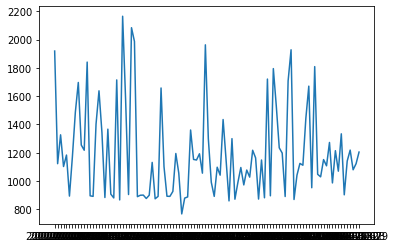

In [ ]:
test_ = df_merge_smaller[df_merge_smaller['Label']==100].sort_values(by="Date")
print(test_.shape)

plt.plot(test_["Date"],test_["Temp_BB_Label_Day"])
plt.show()

#Plot the center_most points from each cluster on the map according to whether temperature above 1400K or below 1400K on one day

In [ ]:
df_selected = df_merge_smaller.copy()
unique_dates = df_selected["Date"].unique()
df_selected = df_selected[(df_selected["Above_1400K"]) & (df_selected["Date"]==unique_dates[0])]

df_selected['text'] = 'RH:=' + df_selected['RH'].astype(str) + ' <br>RHI:=' + df_selected['RHI'].astype(str) + ' <br>Temp_BB: '+ df_selected['Temp_BB'].astype(str)+ ' <br>Area_BB: '+ df_selected['Area_BB'].astype(str)
fig = go.Figure(data = go.Scattergeo(
    lon = df_selected["Lon_GMTCO"],
    lat = df_selected["Lat_GMTCO"],
    text = df_selected["text"],
    mode = "markers",
    marker = dict(
        size = 10,
        opacity = 0.8,
        reversescale = True, # set the reversescale and autocolorscale as True to enable the color of markers automatically changed
        autocolorscale = True,
        symbol = 'x',
        line = dict(
            width = 1,
            color = 'rgba(102, 102, 102)'
        ),
        cmin = 0, # cmin/cmax == lower/upper bound of the color domain for the data points
        color = df_selected['Temp_BB'],
        cmax = df_selected['Temp_BB'].max(), #
        colorbar_title = "Temperature"
    )
))

fig.update_layout(
    title = "BRAINWAVE - GAS FLARING",
    geo = dict(
        scope = "world", # ccope options: world, usa, europe, africa, north america, south america
        showland = True,
    )
)

fig.show()
#fig.write_html('first_figure.html', auto_open=True) #generate a HTML page that shows the scatter map

In [ ]:
df_selected.describe()

,Lat_GMTCO,Lon_GMTCO,Temp_BB,RHI,RH,Area_BB,Cloud_Mask,Sample_M10,Label,Temp_BB_Label,Temp_BB_Label_Day,Lat_GMTCO_Label,Lon_GMTCO_Label
count,1.257792e+06,1.257792e+06,1.257792e+06,1.257792e+06,1.257792e+06,1.257792e+06,1.185391e+06,1.257792e+06,1.257792e+06,1.257792e+06,1.257792e+06,1.257792e+06,1.257792e+06
mean,2.961542e+01,2.910411e+01,1.763941e+03,6.181641e+00,6.560951e+00,1.518828e+01,7.443282e-01,1.597628e+03,2.741208e+01,2.496249e+03,2.394911e+03,2.955952e+01,3.446434e+01
std,2.292006e+01,6.096863e+01,1.995990e+02,1.720271e+01,1.820597e+01,4.949244e+01,1.219341e+00,9.561749e+02,1.396223e+02,3.143745e+01,1.710430e+02,2.208484e+01,6.223474e+01
min,-8.619746e+01,-1.792983e+02,1.400000e+03,1.100280e-03,8.636560e-04,4.636030e-04,0.000000e+00,1.000000e+00,0.000000e+00,1.402000e+03,1.400000e+03,-8.619746e+01,-1.792983e+02
25%,1.822076e+01,6.710423e+00,1.632000e+03,1.125720e+00,1.065587e+00,1.703550e+00,0.000000e+00,7.710000e+02,2.000000e+00,2.500000e+03,2.389000e+03,2.815325e+01,9.484200e+00
50%,3.065623e+01,4.744994e+01,1.748000e+03,2.112940e+00,2.231130e+00,4.748490e+00,0.000000e+00,1.595000e+03,3.000000e+00,2.500000e+03,2.473000e+03,4.023029e+01,6.968580e+01
75%,4.590083e+01,5.810152e+01,1.873000e+03,4.677550e+00,5.138947e+00,1.205980e+01,1.000000e+00,2.429000e+03,1.700000e+01,2.500000e+03,2.492000e+03,4.023029e+01,6.968580e+01
max,8.268616e+01,1.798375e+02,2.500000e+03,9.743510e+02,1.604220e+03,5.688500e+03,3.000000e+00,3.200000e+03,8.352000e+03,2.500000e+03,2.500000e+03,8.292818e+01,1.789818e+02
